<a href="https://colab.research.google.com/github/Satomiko/20Newsgroups/blob/main/Subsets_Experiment_and_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install nltk

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import LancasterStemmer
from nltk.stem import PorterStemmer
import string
from wordcloud import WordCloud, STOPWORDS
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB #for multinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report #for evaluation report
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
#after the review of text preprocessing method in "2. preprocessing methods.ipybb", the following function was created for text preprocessing
#"preprocess_text" function will be used to clean text data within this project. (All data was cleaned by same method)

def preprocess_text(df, column_name):
    # Lowercasing
    df[column_name] = df[column_name].apply(lambda tokens: [token.lower() for token in tokens])

    # Stop Word Removal
    stop_words = set(stopwords.words('english'))
    df[column_name] = df[column_name].apply(lambda tokens: [word for word in tokens if word not in stop_words])

    # Removing one-letter words
    df[column_name] = df[column_name].apply(lambda tokens: [word for word in tokens if len(word) > 1])

    # Remove special symbols and punctuation
    df[column_name] = df[column_name].apply(lambda tokens: [word for word in tokens if word.isalpha()])

    # Lemmatizing
    lemmatizer = WordNetLemmatizer()
    df[column_name] = df[column_name].apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])

In [4]:
def word_count (df,colomn_name):
  df['word_count'] = df [colomn_name].apply(len)
  average_word_count = df['word_count'].mean()
  max_word_count = df['word_count'].max()
  minimum_word_count = df['word_count'].min()
  print(f"Average Word Count :{average_word_count}")
  print(f"Maximum Word Count :{max_word_count}")
  print(f"Minimum Word Count :{minimum_word_count}")


In [5]:

#list of machine learning models used in the project
classifiers = {
    'Multinomial Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Support Vector Machines': SVC(),
    'Decision Trees': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

In [6]:
#use "fetch_20newsgroups" function from sklean.datasets  to load 20 newsgroups dataset
# removing "headers", "footers" and "quotes" is recommended because it is more realistic (https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html)
# loading dataset with or without "headers", "footers" and "quotes" and review each datasets.

remove = ("headers", "footers", "quotes")

cats1=['comp.graphics','talk.politics.mideast','soc.religion.christian','rec.autos','sci.crypt']  #from different primary group
cats2=['comp.graphics','comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware','comp.sys.mac.hardware','comp.windows.x'] #from same primary group


**Subset 1 (Different categries)**

In [7]:
sub1_train = fetch_20newsgroups(subset='train', remove = remove, categories=cats1)
sub1_test = fetch_20newsgroups (subset='test', remove= remove, categories=cats1)

In [8]:
categories1 = sub1_train.target_names
categories1

['comp.graphics',
 'rec.autos',
 'sci.crypt',
 'soc.religion.christian',
 'talk.politics.mideast']

In [9]:
len(sub1_train.data)

2936

In [10]:
len(sub1_test.data)

1955

In [11]:
#count observation in each category (Train Data)

cat,frequency_train = np.unique(sub1_train.target, return_counts = True)
cat,frequency_train

(array([0, 1, 2, 3, 4]), array([584, 594, 595, 599, 564]))

In [12]:
#count observation in each category (Test Data)

cat,frequency_test = np.unique(sub1_test.target, return_counts = True)
cat,frequency_test

(array([0, 1, 2, 3, 4]), array([389, 396, 396, 398, 376]))

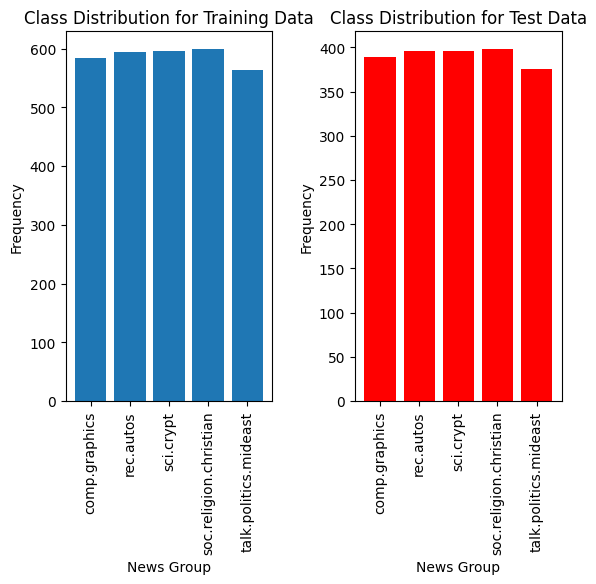

In [13]:
cat = np.array(sub1_test.target_names)
#create bar plots for both training data and test data to compare the distribution

#subplot 1 for training data distribution
plt.subplot(1,2,1) #1 row, 2 columns, position 1
plt.bar(cat, frequency_train)
plt.xticks(rotation=90)
plt.title('Class Distribution for Training Data')
plt.xlabel('News Group')
plt.ylabel('Frequency')

#subplot 2 for test data distribution
plt.subplot(1,2,2) #1 row, 2 columns, position 2
plt.bar(cat, frequency_test, color = 'red')
plt.xticks(rotation=90)
plt.title('Class Distribution for Test Data')
plt.xlabel('News Group')
plt.ylabel('Frequency')

plt.subplots_adjust(wspace=0.4) #increase horisontal space
plt.show()

In [14]:
#Convert Bunch format to dataframe
train_df_1 = pd.DataFrame({'data': sub1_train.data, 'target': sub1_train.target})
test_df_1 = pd.DataFrame({'data': sub1_test.data, 'target': sub1_test.target})

In [15]:
#Tokenization
train_df_1 ['data'] = train_df_1['data'] .apply(word_tokenize)
test_df_1['data']= test_df_1 ['data']. apply(word_tokenize)

In [16]:
preprocess_text(train_df_1, 'data')
preprocess_text(test_df_1,'data')

In [17]:
# Remove rows with empty or whitespace strings in the "data" column
train_df_1 = train_df_1[train_df_1['data'].apply(len) > 0]
test_df_1 = test_df_1[test_df_1['data'].apply(len) > 0]

In [18]:
word_count(train_df_1,'data')

Average Word Count :115.4011934011934
Maximum Word Count :4777
Minimum Word Count :1


<ipython-input-4-fbcef87b117d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['word_count'] = df [colomn_name].apply(len)


In [19]:
word_count(test_df_1,'data')

Average Word Count :119.35683987274655
Maximum Word Count :4714
Minimum Word Count :1


<ipython-input-4-fbcef87b117d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['word_count'] = df [colomn_name].apply(len)


In [20]:
train_df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2849 entries, 0 to 2935
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   data        2849 non-null   object
 1   target      2849 non-null   int64 
 2   word_count  2849 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 89.0+ KB


In [21]:
train_df_1['target']=train_df_1["target"].astype("category")
test_df_1["target"]=test_df_1["target"].astype("category")

<ipython-input-21-3b1ee911e726>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_1['target']=train_df_1["target"].astype("category")
<ipython-input-21-3b1ee911e726>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_1["target"]=test_df_1["target"].astype("category")


In [22]:
train_df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2849 entries, 0 to 2935
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   data        2849 non-null   object  
 1   target      2849 non-null   category
 2   word_count  2849 non-null   int64   
dtypes: category(1), int64(1), object(1)
memory usage: 69.8+ KB


In [23]:
test_df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1886 entries, 0 to 1954
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   data        1886 non-null   object  
 1   target      1886 non-null   category
 2   word_count  1886 non-null   int64   
dtypes: category(1), int64(1), object(1)
memory usage: 46.3+ KB


In [24]:
train_df_1.head()

data target  word_count
0  [atrocity, report, horrify, azerbaijan, azeri,...      4          77
1  [account, human, right, violation, azerbaijan,...      4        2524
2  [anyone, know, good, shareware, animation, pai...      0          21
3  [trying, avoid, discussion, whether, clinton, ...      4          21
4  [far, know, isdn, call, swissnet, plugged, bit...      2          23

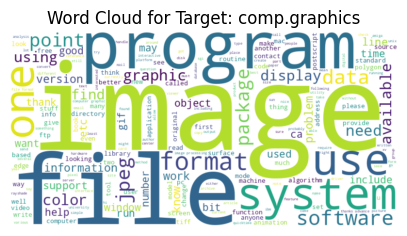

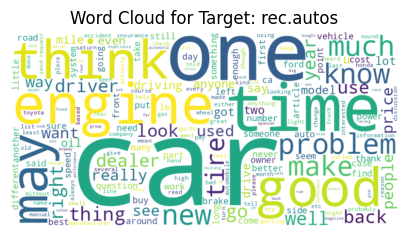

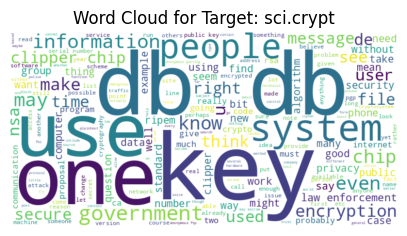

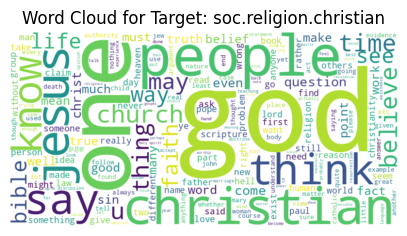

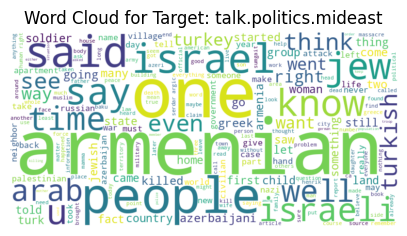

In [25]:
group_train_df_1 = train_df_1.groupby('target')

# Create a word cloud for each target
for target, group in group_train_df_1:
    # Combine the text data from the group into a single string
    combined_text = " ".join(group['data'].apply(lambda x: ' '.join(x)))

    # Generate a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

    # Display the word cloud with the target as the title
    target_name= categories1[target]
    plt.figure(figsize=(5, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for Target: {target_name}")
    plt.axis("off")
    plt.show()

In [26]:
# TF-IDF

train_df_1['data'] = train_df_1['data'].apply(lambda tokens: ' '.join(tokens))
test_df_1['data'] =test_df_1['data'].apply(lambda tokens:' '.join(tokens))

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X1_train = tfidf_vectorizer.fit_transform(train_df_1['data'])

X1_test = tfidf_vectorizer.transform(test_df_1['data'])

In [27]:
print(X1_train.shape)

(2849, 5000)


In [28]:
feature_names = tfidf_vectorizer.get_feature_names_out()
# Convert the TF-IDF matrix to a DataFrame
tfidf_df_1 = pd.DataFrame(X1_train.toarray(), columns=feature_names)

In [29]:

tfidf_df_1.head()

ab  abandoned  abc  ability      able  abraham  abroad  absence  absolute  \
0  0.0        0.0  0.0      0.0  0.000000      0.0     0.0      0.0       0.0   
1  0.0        0.0  0.0      0.0  0.006072      0.0     0.0      0.0       0.0   
2  0.0        0.0  0.0      0.0  0.000000      0.0     0.0      0.0       0.0   
3  0.0        0.0  0.0      0.0  0.000000      0.0     0.0      0.0       0.0   
4  0.0        0.0  0.0      0.0  0.000000      0.0     0.0      0.0       0.0   

   absolutely  ...  york     young  younger  youth  yugoslavia  zealand  zero  \
0         0.0  ...   0.0  0.000000      0.0    0.0         0.0      0.0   0.0   
1         0.0  ...   0.0  0.024132      0.0    0.0         0.0      0.0   0.0   
2         0.0  ...   0.0  0.000000      0.0    0.0         0.0      0.0   0.0   
3         0.0  ...   0.0  0.000000      0.0    0.0         0.0      0.0   0.0   
4         0.0  ...   0.0  0.000000      0.0    0.0         0.0      0.0   0.0   

   zionism  zionist  zone  
0      0.0      0.0   0.0  
1      0.0      0.0   0.0  
2      0.0      0.0   0.0  
3      0.0      0.0   0.0  
4      0.0      0.0   0.0  

[5 rows x 5000 columns]

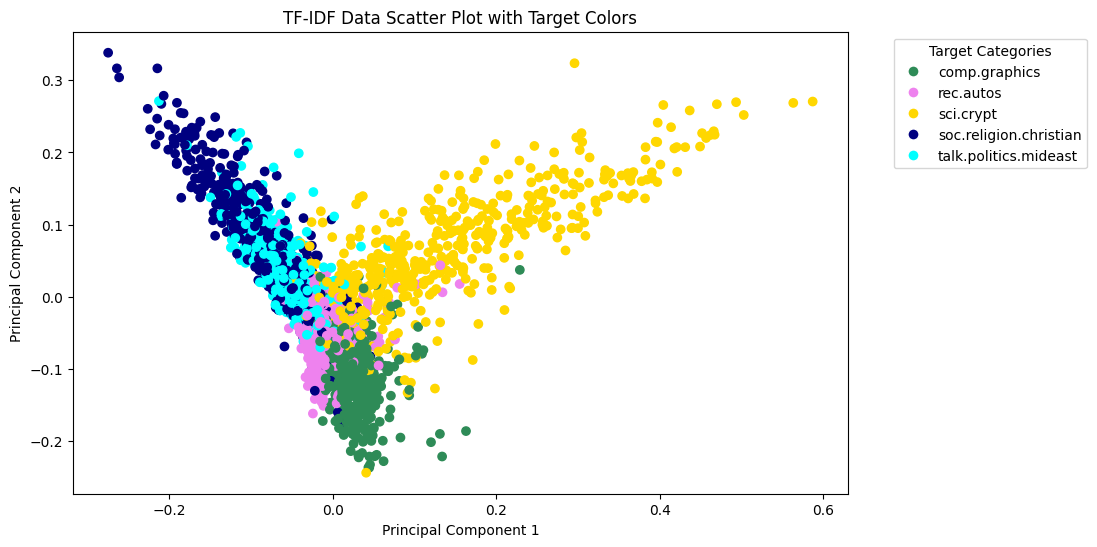

In [30]:
# Reduce the dimensionality of the TF-IDF data using PCA to make scatter plot.


#create custom color list
custom_colors=['seagreen','violet','gold','navy','cyan']
# Create a custom colormap from the custom color list
custom_cmap = ListedColormap(custom_colors)

pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
tfidf_df_reduced_1 = pca.fit_transform(tfidf_df_1)

# convert tfidf_df_reduced (array) to dataframe. There are 2 components (attribute) for this dataframe
tfidf_df_reduced_1 = pd.DataFrame(tfidf_df_reduced_1, columns=['PC1', 'PC2'])


# Add the 'target' column to tfidf_df_reduced for labeling purpose
tfidf_df_reduced_1['target'] = pd.Categorical(train_df_1['target'])

# Create a scatter plot with colors representing the target labels
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    tfidf_df_reduced_1['PC1'],
    tfidf_df_reduced_1['PC2'],
    c=tfidf_df_reduced_1['target'].cat.codes,  # Use categorical codes for color-coding
    cmap=custom_cmap
)

# Add legend with target category names and colors
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', label=category_name, markersize=8, markerfacecolor=color)
                 for category_name, color in zip(categories1, custom_colors)]

plt.legend(handles=legend_labels, title='Target Categories',bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('TF-IDF Data Scatter Plot with Target Colors')
plt.show()

In [31]:
#for Multinomial NaiveBayes method, use "MultinomialNB" function fromsklearn.naive_bayes
nb_classifier = MultinomialNB()
nb_classifier.fit(X1_train, train_df_1['target'])

MultinomialNB()

In [32]:
# use "accuracy_score" and "classification_report" function from sklearn.metrics

predictions = nb_classifier.predict(X1_test)
accuracy = accuracy_score(test_df_1['target'], predictions)

report = classification_report(test_df_1['target'], predictions, target_names=sub1_train.target_names)
print(f'Accuracy: {accuracy}')
print(report)

Accuracy: 0.8796394485683987
                        precision    recall  f1-score   support

         comp.graphics       0.87      0.87      0.87       384
             rec.autos       0.91      0.91      0.91       370
             sci.crypt       0.88      0.83      0.85       378
soc.religion.christian       0.81      0.97      0.88       384
 talk.politics.mideast       0.95      0.82      0.88       370

              accuracy                           0.88      1886
             macro avg       0.88      0.88      0.88      1886
          weighted avg       0.88      0.88      0.88      1886



Multinomial Naive Bayes:
Cross-validation scores: [0.91578947 0.89649123 0.87894737 0.88596491 0.89455185]
Mean accuracy: 0.8943489655597693
Test accuracy: 0.8796394485683987

Logistic Regression:
Cross-validation scores: [0.91754386 0.88596491 0.88070175 0.88245614 0.89630931]
Mean accuracy: 0.8925951962507324
Test accuracy: 0.8860021208907741

Support Vector Machines:
Cross-validation scores: [0.90350877 0.89824561 0.88245614 0.88070175 0.89455185]
Mean accuracy: 0.8918928252088921
Test accuracy: 0.8817603393425238

Decision Trees:
Cross-validation scores: [0.75964912 0.72105263 0.73157895 0.73508772 0.75219684]
Mean accuracy: 0.7399130515215984
Test accuracy: 0.6871686108165429

Random Forest:
Cross-validation scores: [0.87719298 0.82631579 0.81754386 0.82280702 0.85237258]
Mean accuracy: 0.8392464465205192
Test accuracy: 0.8170731707317073



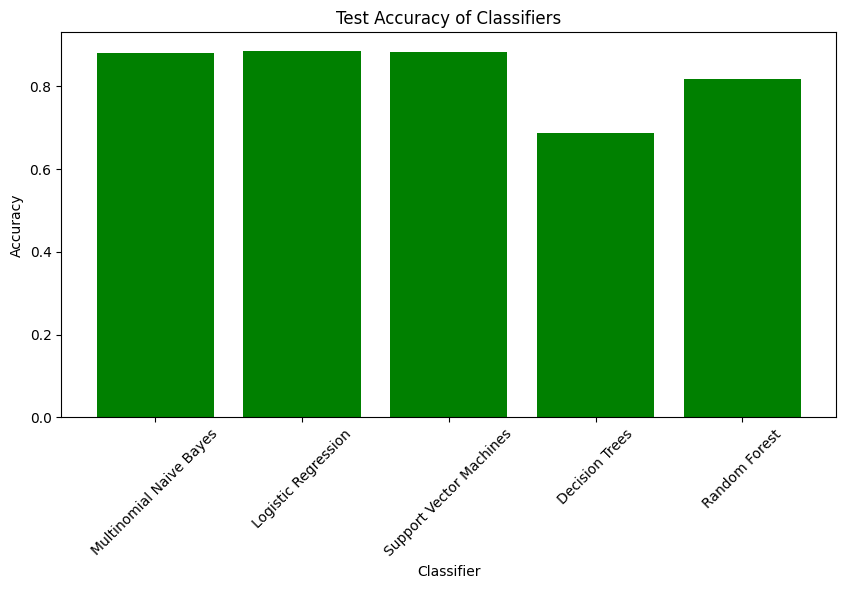

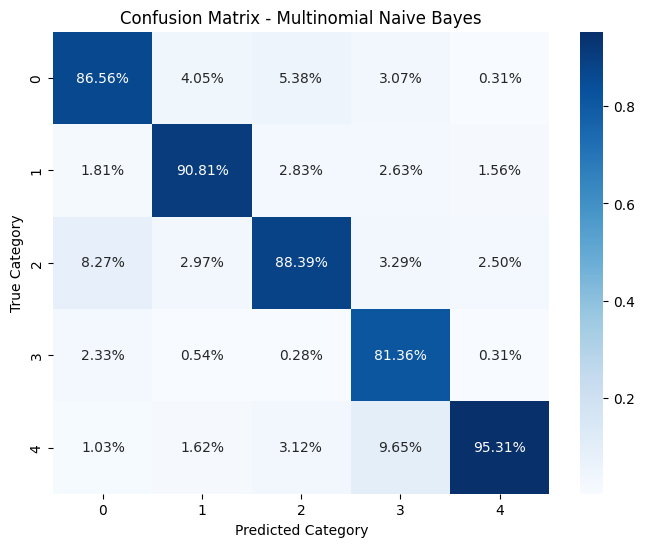

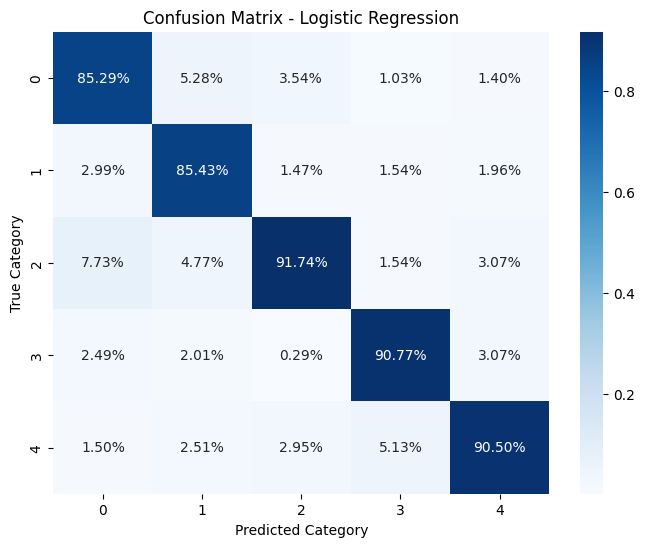

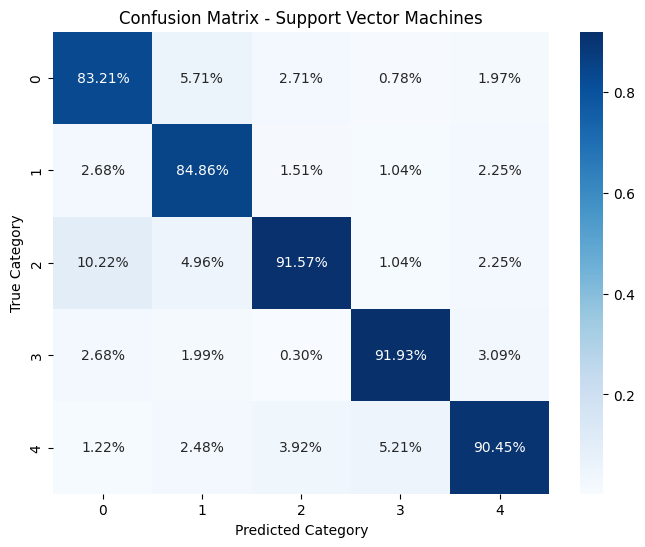

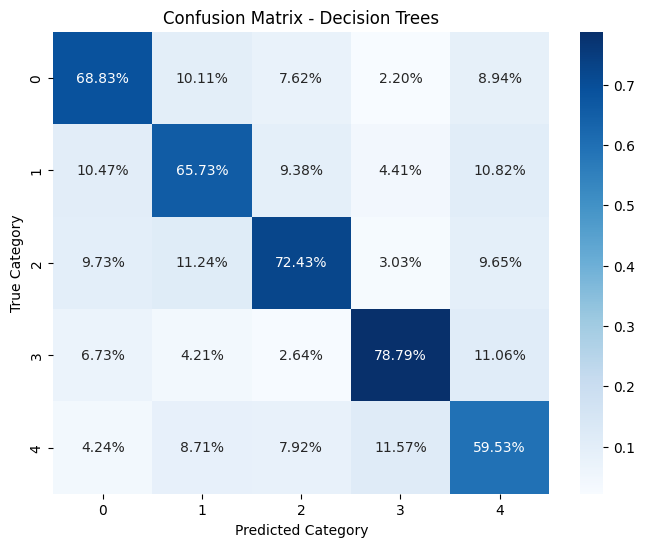

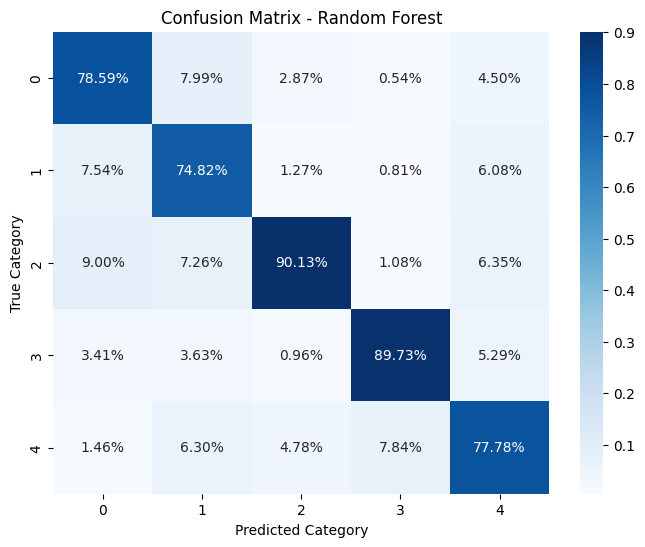

In [84]:
# Lists to store results
classifier_names1 = []
cross_val_scores1 = []
test_accuracies1 = []
confusion_matrices1 = []

# Loop through each classifier and perform cross-validation
for name, classifier in classifiers.items():
    # Perform cross-validation on the classifier using X1_train and the target
    scores = cross_val_score(classifier, X1_train, train_df_1['target'], cv=5)  # cross_val_score(classification model, Training data, target attribute, K=5)  #5 fold cross validation

    # Train the classifier on X1_train and the target
    classifier.fit(X1_train, train_df_1['target'])

    # Use the trained classifier to make predictions on X1_test
    predictions = classifier.predict(X1_test)

    # Evaluate the accuracy on X1_test
    accuracy = accuracy_score(test_df_1['target'], predictions)

    # Generate the confusion matrix
    confusion = confusion_matrix(test_df_1['target'], predictions)

    # Store the results
    classifier_names1.append(name)
    cross_val_scores1.append(scores.mean())
    test_accuracies1.append(accuracy)
    confusion_matrices1.append(confusion)

    # Print the cross-validation results for the current classifier
    print(f'{name}:')
    print(f'Cross-validation scores: {scores}')
    print(f'Mean accuracy: {scores.mean()}')
    print(f'Test accuracy: {accuracy}\n')

# Create a bar plot for accuracy performance
plt.figure(figsize=(10, 5))
plt.bar(classifier_names1, test_accuracies1, color='green')
plt.title('Test Accuracy of Classifiers')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

# Show the bar plot
plt.show()

# Create heat maps of confusion matrices with classifier names as titles
for i, name in enumerate(classifier_names1):
    plt.figure(figsize=(8, 6))

    # Normalize the confusion matrix to percentages per column (predicted values)
    normalized_confusion_matrix = confusion_matrices1[i] / confusion_matrices1[i].sum(axis=0)

    sns.heatmap(normalized_confusion_matrix, annot=True, fmt='.2%', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted Category')
    plt.ylabel('True Category')

    # Show the heat map
    plt.show()

**Subset 2 (Similar categories)**


In [34]:
sub2_train = fetch_20newsgroups(subset='train', remove = remove, categories=cats2)
sub2_test = fetch_20newsgroups (subset='test', remove= remove, categories=cats2)

In [35]:
categories2 = sub2_train.target_names
categories2

['comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x']

In [36]:
len(sub2_train.data)

2936

In [37]:
len(sub2_test.data)

1955

In [38]:
#count observation in each category (Train Data)

cat,frequency_train = np.unique(sub2_train.target, return_counts = True)
cat,frequency_train

(array([0, 1, 2, 3, 4]), array([584, 591, 590, 578, 593]))

In [39]:
#count observation in each category (Test Data)

cat,frequency_test = np.unique(sub2_test.target, return_counts = True)
cat,frequency_test

(array([0, 1, 2, 3, 4]), array([389, 394, 392, 385, 395]))

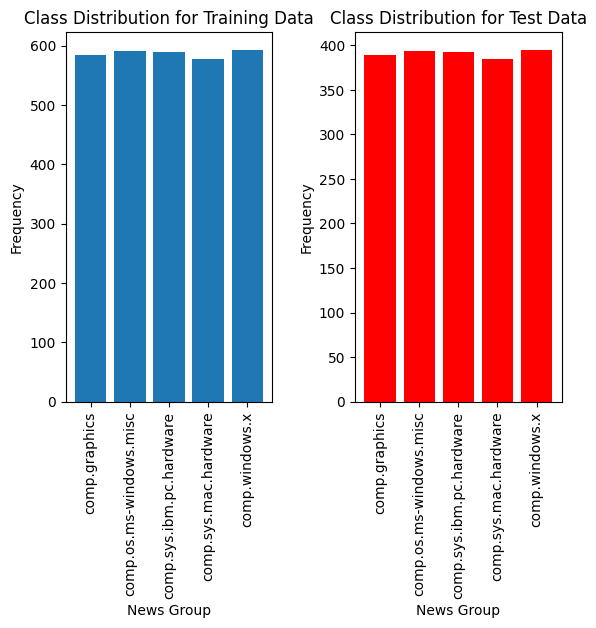

In [40]:
cat = np.array(sub2_test.target_names)
#create bar plots for both training data and test data to compare the distribution

#subplot 1 for training data distribution
plt.subplot(1,2,1) #1 row, 2 columns, position 1
plt.bar(cat, frequency_train)
plt.xticks(rotation=90)
plt.title('Class Distribution for Training Data')
plt.xlabel('News Group')
plt.ylabel('Frequency')

#subplot 2 for test data distribution
plt.subplot(1,2,2) #1 row, 2 columns, position 2
plt.bar(cat, frequency_test, color = 'red')
plt.xticks(rotation=90)
plt.title('Class Distribution for Test Data')
plt.xlabel('News Group')
plt.ylabel('Frequency')

plt.subplots_adjust(wspace=0.4) #increase horisontal space
plt.show()

In [41]:
#Convert Bunch format to dataframe
train_df_2 = pd.DataFrame({'data': sub2_train.data, 'target': sub2_train.target})
test_df_2 = pd.DataFrame({'data': sub2_test.data, 'target': sub2_test.target})

In [42]:
#Tokenization
train_df_2 ['data'] = train_df_2['data'] .apply(word_tokenize)
test_df_2['data']= test_df_2 ['data']. apply(word_tokenize)

In [43]:
preprocess_text(train_df_2,'data')
preprocess_text(test_df_2,'data')

In [44]:
# Remove rows with empty or whitespace strings in the "data" column
train_df_2 = train_df_2[train_df_2['data'].apply(len) > 0]
test_df_2 = test_df_2[test_df_2['data'].apply(len) > 0]

In [45]:
train_df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2857 entries, 0 to 2935
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   data    2857 non-null   object
 1   target  2857 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 67.0+ KB


In [46]:
test_df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1909 entries, 0 to 1954
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   data    1909 non-null   object
 1   target  1909 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 44.7+ KB


In [47]:
print("[Train]")
word_count(train_df_2,'data')
print("[Test]")
word_count(test_df_2,'data')

[Train]
Average Word Count :80.59012950647532
Maximum Word Count :4890
Minimum Word Count :1
[Test]
Average Word Count :83.40335254059717
Maximum Word Count :4714
Minimum Word Count :1


<ipython-input-4-fbcef87b117d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['word_count'] = df [colomn_name].apply(len)
<ipython-input-4-fbcef87b117d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['word_count'] = df [colomn_name].apply(len)


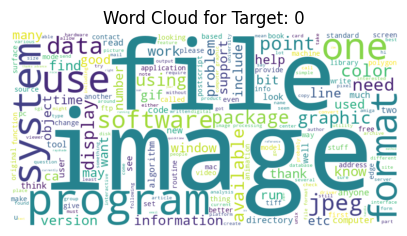

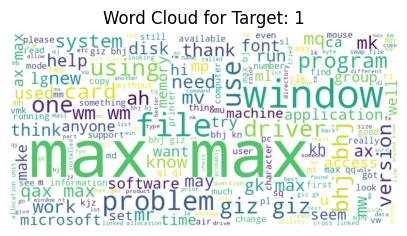

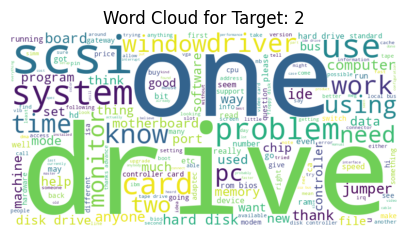

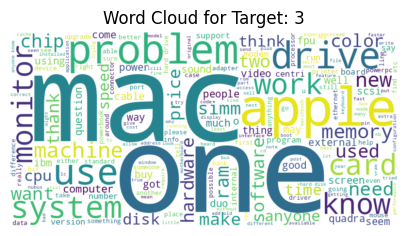

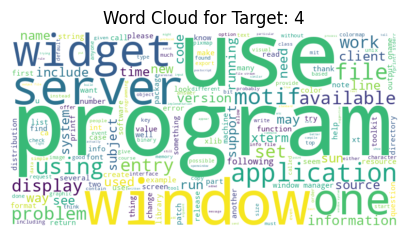

In [48]:
group_train_df_2 = train_df_2.groupby('target')

# Create a word cloud for each target
for target, group in group_train_df_2:
    # Combine the text data from the group into a single string
    combined_text = " ".join(group['data'].apply(lambda x: ' '.join(x)))

    # Generate a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

    # Display the word cloud with the target as the title
    plt.figure(figsize=(5, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for Target: {target}")
    plt.axis("off")
    plt.show()

In [49]:
# TF-IDF

train_df_2['data'] = train_df_2['data'].apply(lambda tokens: ' '.join(tokens))
test_df_2['data'] =test_df_2['data'].apply(lambda tokens:' '.join(tokens))

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X2_train = tfidf_vectorizer.fit_transform(train_df_2['data'])

X2_test = tfidf_vectorizer.transform(test_df_2['data'])

In [50]:
feature_names = tfidf_vectorizer.get_feature_names_out()
# Convert the TF-IDF matrix to a DataFrame
tfidf_df_2 = pd.DataFrame(X2_train.toarray(), columns=feature_names)

In [51]:
tfidf_df_2.head()

aa   ab  abc  abcdefghijklmnopqrstuvwxyz  ability     able  abort  \
0  0.0  0.0  0.0                         0.0      0.0  0.00000    0.0   
1  0.0  0.0  0.0                         0.0      0.0  0.00000    0.0   
2  0.0  0.0  0.0                         0.0      0.0  0.00000    0.0   
3  0.0  0.0  0.0                         0.0      0.0  0.00000    0.0   
4  0.0  0.0  0.0                         0.0      0.0  0.07147    0.0   

   absolute  absolutely  abstract  ...  zri  zrlk  zrmc   zu  zuo   zv  zvm  \
0       0.0         0.0       0.0  ...  0.0   0.0   0.0  0.0  0.0  0.0  0.0   
1       0.0         0.0       0.0  ...  0.0   0.0   0.0  0.0  0.0  0.0  0.0   
2       0.0         0.0       0.0  ...  0.0   0.0   0.0  0.0  0.0  0.0  0.0   
3       0.0         0.0       0.0  ...  0.0   0.0   0.0  0.0  0.0  0.0  0.0   
4       0.0         0.0       0.0  ...  0.0   0.0   0.0  0.0  0.0  0.0  0.0   

    zy  zyxel   zz  
0  0.0    0.0  0.0  
1  0.0    0.0  0.0  
2  0.0    0.0  0.0  
3  0.0    0.0  0.0  
4  0.0    0.0  0.0  

[5 rows x 5000 columns]

In [52]:

# Calculate the mean TF-IDF score for each attribute (word)
attribute_means = tfidf_df_2.mean()

# Sort the attributes by their mean TF-IDF scores in descending order
top_10_attributes = attribute_means.sort_values(ascending=False).head(10)

# Print the top 10 most common attributes
print("Top 10 Most Common Attributes:")
print(top_10_attributes)

Top 10 Most Common Attributes:
window     0.027560
file       0.023517
would      0.022336
know       0.021361
thanks     0.020980
problem    0.020750
one        0.020560
drive      0.020077
get        0.019742
use        0.019608
dtype: float64


In [53]:
# Create a dictionary to store the top 10 attributes by class
top_10_attributes_by_class = {}

# Iterate through each class
for class_label in set(train_df_2['target']):
    # Filter data for the current class
    class_data = train_df_2[train_df_2['target'] == class_label]['data']

    # Calculate the TF-IDF for the current class
    X_class = tfidf_vectorizer.transform(class_data)

    # Calculate the mean TF-IDF score for each attribute (word) in the class
    class_attribute_means = X_class.mean(axis=0)

    # Get the top 10 attributes for the current class
    top_10_attributes = [feature_names[i] for i in class_attribute_means.argsort()[0, ::-1][:10]]

    # Store the top 10 attributes in the dictionary
    top_10_attributes_by_class[class_label] = top_10_attributes

# Print the top 10 attributes for each class
for class_label, top_10_attributes in top_10_attributes_by_class.items():
    top_10_attributes = top_10_attributes[0]  # Extract the array from the DataFrame
    print(f"Top 10 Attributes for Class {class_label}:")
    for attribute in top_10_attributes:
        print(attribute)
    print()  # Add an empty line to separate classes

Top 10 Attributes for Class 0:
['file' 'image' 'graphic' ... 'mbxom' 'maxtor' 'aa']

Top 10 Attributes for Class 1:
['window' 'file' 'driver' ... 'prodrive' 'production' 'keysym']

Top 10 Attributes for Class 2:
['drive' 'card' 'controller' ... 'mj' 'mit' 'aa']

Top 10 Attributes for Class 3:
['mac' 'apple' 'drive' ... 'mri' 'mrd' 'aa']

Top 10 Attributes for Class 4:
['window' 'server' 'widget' ... 'lipman' 'literature' 'aa']



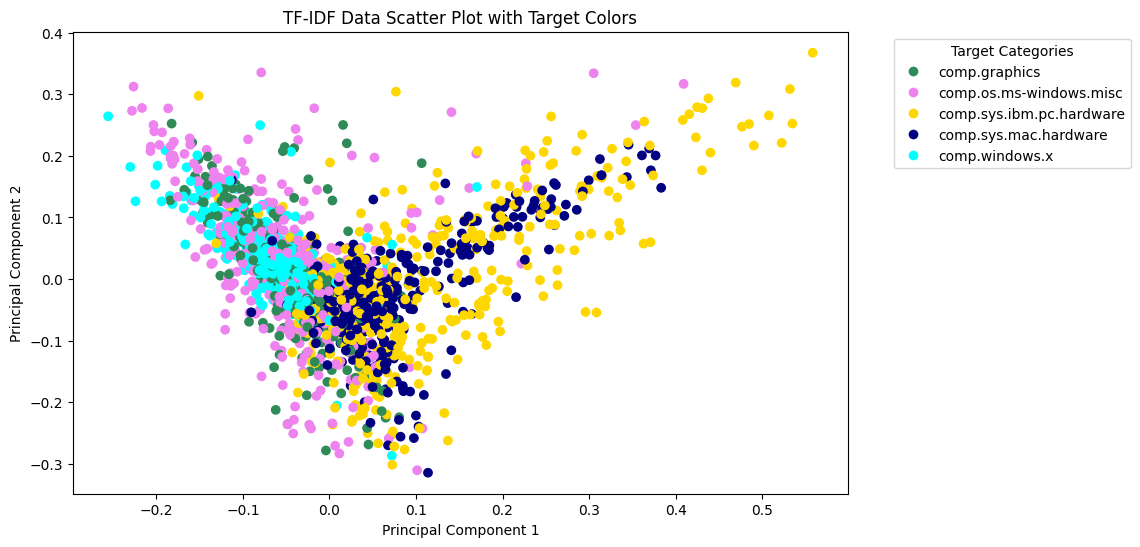

In [54]:
# Reduce the dimensionality of the TF-IDF data using PCA to make scatter plot.

pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
tfidf_df_reduced_2 = pca.fit_transform(tfidf_df_2)

# convert tfidf_df_reduced (array) to dataframe. There are 2 components (attribute) for this dataframe
tfidf_df_reduced_2 = pd.DataFrame(tfidf_df_reduced_2, columns=['PC1', 'PC2'])


# Add the 'target' column to tfidf_df_reduced for labeling purpose
tfidf_df_reduced_2['target'] = pd.Categorical(train_df_2['target'])

# Create a scatter plot with colors representing the target labels
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    tfidf_df_reduced_2['PC1'],
    tfidf_df_reduced_2['PC2'],
    c=tfidf_df_reduced_2['target'].cat.codes,  # Use categorical codes for color-coding
    cmap=custom_cmap
)

# Add legend with target category names and colors
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', label=category_name, markersize=8, markerfacecolor=color)
                 for category_name, color in zip(categories2, custom_colors)]

plt.legend(handles=legend_labels, title='Target Categories',bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('TF-IDF Data Scatter Plot with Target Colors')
plt.show()

In [55]:
#for Multinomial NaiveBayes method, use "MultinomialNB" function fromsklearn.naive_bayes
nb_classifier = MultinomialNB()
nb_classifier.fit(X2_train, train_df_2['target'])

MultinomialNB()

In [56]:
# use "accuracy_score" and "classification_report" function from sklearn.metrics

predictions = nb_classifier.predict(X2_test)
accuracy = accuracy_score(test_df_2['target'], predictions)

report = classification_report(test_df_2['target'], predictions, target_names=sub2_train.target_names)
print(f'Accuracy: {accuracy}')
print(report)

Accuracy: 0.7024620220010477
                          precision    recall  f1-score   support

           comp.graphics       0.72      0.71      0.72       384
 comp.os.ms-windows.misc       0.67      0.58      0.62       379
comp.sys.ibm.pc.hardware       0.64      0.75      0.69       385
   comp.sys.mac.hardware       0.72      0.72      0.72       371
          comp.windows.x       0.77      0.75      0.76       390

                accuracy                           0.70      1909
               macro avg       0.70      0.70      0.70      1909
            weighted avg       0.70      0.70      0.70      1909



Multinomial Naive Bayes:
Cross-validation scores: [0.75524476 0.7534965  0.7793345  0.72329247 0.73204904]
Mean accuracy: 0.7486834531493025
Test accuracy: 0.7024620220010477

Logistic Regression:
Cross-validation scores: [0.75699301 0.73251748 0.76532399 0.73730298 0.72329247]
Mean accuracy: 0.7430859858180348
Test accuracy: 0.6951283394447355

Support Vector Machines:
Cross-validation scores: [0.77272727 0.7465035  0.76882662 0.7408056  0.73380035]
Mean accuracy: 0.7525326687323185
Test accuracy: 0.6898899947616554

Decision Trees:
Cross-validation scores: [0.61013986 0.58216783 0.52364273 0.53415061 0.53765324]
Mean accuracy: 0.5575508554492793
Test accuracy: 0.5238344683080147

Random Forest:
Cross-validation scores: [0.71153846 0.67482517 0.68126095 0.66024518 0.69001751]
Mean accuracy: 0.6835774558191371
Test accuracy: 0.6616029334730226



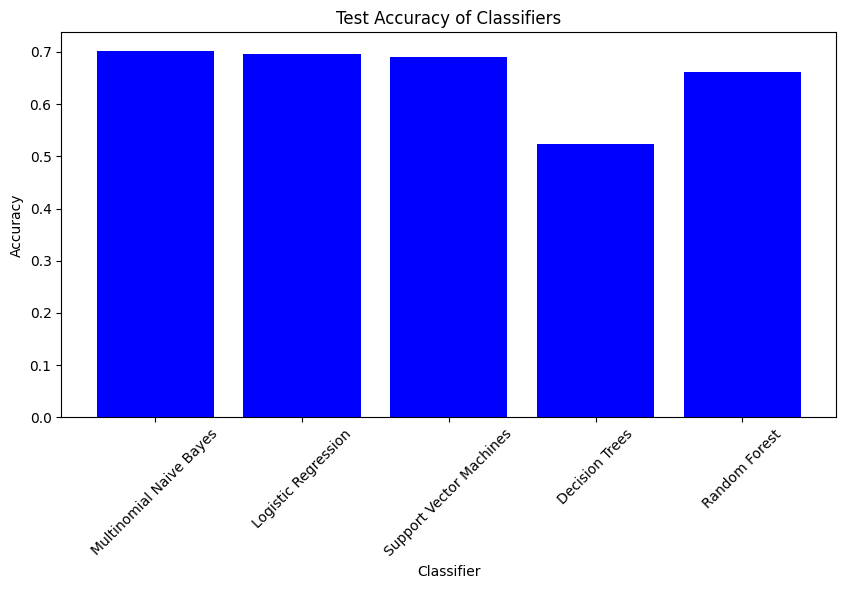

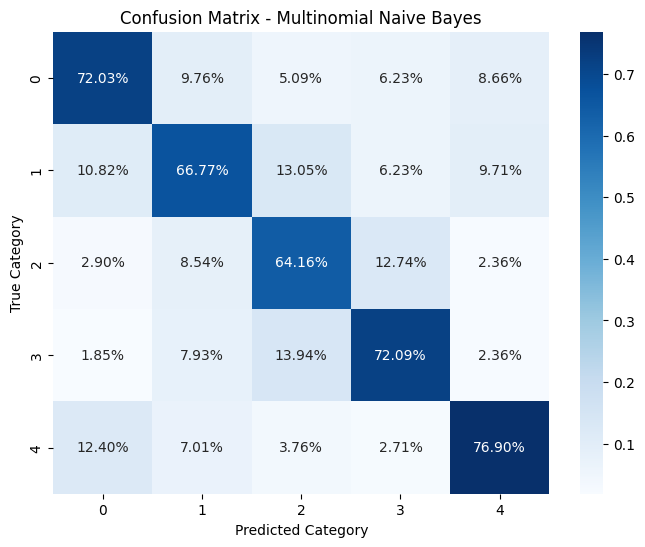

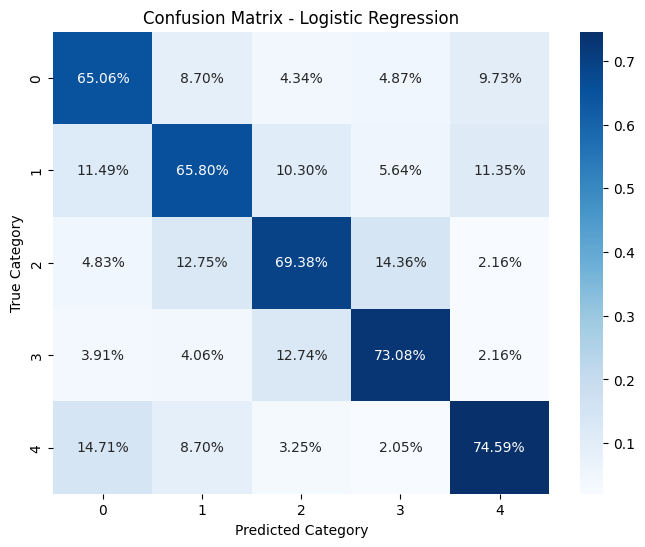

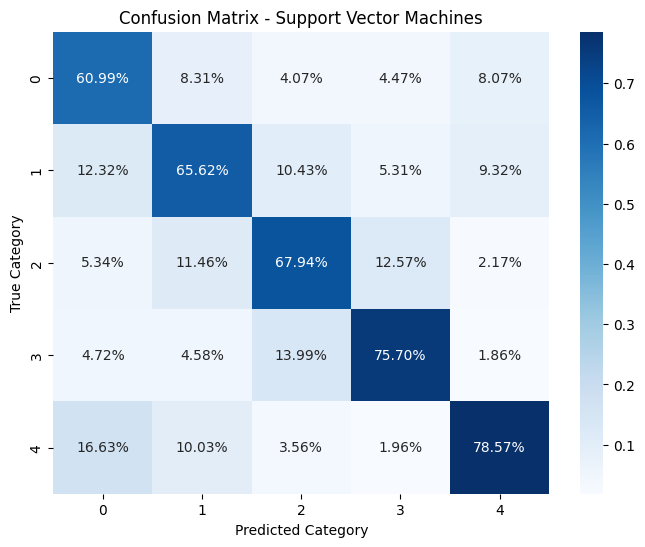

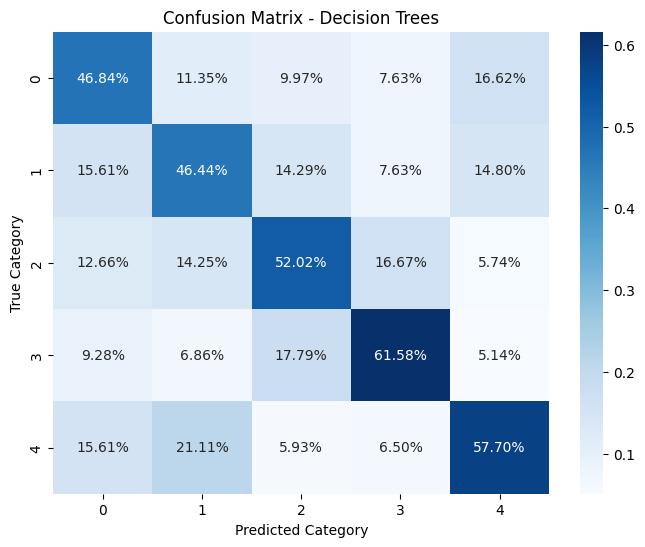

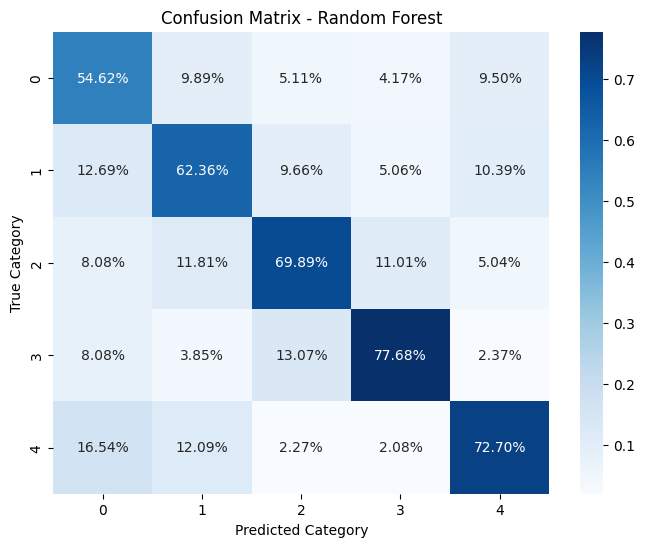

In [87]:
# Lists to store results
classifier_names2 = []
cross_val_scores2 = []
test_accuracies2 = []
confusion_matrices2 = []

# Loop through each classifier and perform cross-validation
for name, classifier in classifiers.items():
    # Perform cross-validation on the classifier using X1_train and the target
    scores = cross_val_score(classifier, X2_train, train_df_2['target'], cv=5)  # cross_val_score(classification model, Training data, target attribute, K=5)  #5 fold cross validation

    # Train the classifier on X2_train and the target
    classifier.fit(X2_train, train_df_2['target'])

    # Use the trained classifier to make predictions on X2_test
    predictions = classifier.predict(X2_test)

    # Evaluate the accuracy on X2_test
    accuracy = accuracy_score(test_df_2['target'], predictions)

    # Generate the confusion matrix
    confusion = confusion_matrix(test_df_2['target'], predictions)

    # Store the results
    classifier_names2.append(name)
    cross_val_scores2.append(scores.mean())
    test_accuracies2.append(accuracy)
    confusion_matrices2.append(confusion)

    # Print the cross-validation results for the current classifier
    print(f'{name}:')
    print(f'Cross-validation scores: {scores}')
    print(f'Mean accuracy: {scores.mean()}')
    print(f'Test accuracy: {accuracy}\n')

# Create a bar plot for accuracy performance
plt.figure(figsize=(10, 5))
plt.bar(classifier_names2, test_accuracies2, color='blue')
plt.title('Test Accuracy of Classifiers')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

# Show the bar plot
plt.show()

# Create heat maps of confusion matrices with classifier names as titles
for i, name in enumerate(classifier_names2):
    plt.figure(figsize=(8, 6))

    # Normalize the confusion matrix to percentages per column (predicted values)
    normalized_confusion_matrix = confusion_matrices2[i] / confusion_matrices2[i].sum(axis=0)

    sns.heatmap(normalized_confusion_matrix, annot=True, fmt='.2%', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted Category')
    plt.ylabel('True Category')

    # Show the heat map
    plt.show()

**Subset 3 (imbalanced)**

In [58]:
remove = ("headers", "footers", "quotes")
news20group_train = fetch_20newsgroups(subset='train', remove = remove)
news20group_test = fetch_20newsgroups (subset='test', remove= remove)


In [59]:
#Convert Bunch format to dataframe
train_df_3 = pd.DataFrame({'data': news20group_train.data, 'target': news20group_train.target})
test_df_3= pd.DataFrame({'data': news20group_test.data, 'target': news20group_test.target})

In [60]:
# Remove rows with the specified target values
train_df_3 = train_df_3[(train_df_3['target'] != 0) & (train_df_3['target'] != 15) & (train_df_3['target'] != 19)]
test_df_3 = test_df_3[(test_df_3['target'] != 0) & (test_df_3['target'] != 15) & (test_df_3['target'] != 19)]

In [61]:
target_mapping = {1: 0,2: 0,3: 0, 4: 0,5: 0, 6: 1, 7: 2, 8: 2, 9: 2, 10: 2, 11: 3, 12: 3, 13: 3, 14: 3, 16: 4, 17: 4, 18: 4}
train_df_3['new_target'] = train_df_3['target'].map(target_mapping)
train_df_3['new_target'] = train_df_3['new_target'].astype(int)
test_df_3['new_target'] = test_df_3['target'].map(target_mapping)
test_df_3['new_target'] = test_df_3['new_target'].astype(int)

In [62]:
categories3=['computer', 'market', 'sports','sceince', 'politics']

In [63]:
train_df_3.head()

data  target  new_target
0  I was wondering if anyone out there could enli...       7           2
1  A fair number of brave souls who upgraded thei...       4           0
2  well folks, my mac plus finally gave up the gh...       4           0
3  \nDo you have Weitek's address/phone number?  ...       1           0
4  From article <C5owCB.n3p@world.std.com>, by to...      14           3

In [64]:
train_df_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9858 entries, 0 to 11313
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   data        9858 non-null   object
 1   target      9858 non-null   int64 
 2   new_target  9858 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 308.1+ KB


In [65]:
train_df_3['new_target']=train_df_3['new_target'].astype("category")
test_df_3['new_target']=test_df_3['new_target'].astype('category')

In [66]:
test_df_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6564 entries, 0 to 7530
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   data        6564 non-null   object  
 1   target      6564 non-null   int64   
 2   new_target  6564 non-null   category
dtypes: category(1), int64(1), object(1)
memory usage: 160.5+ KB


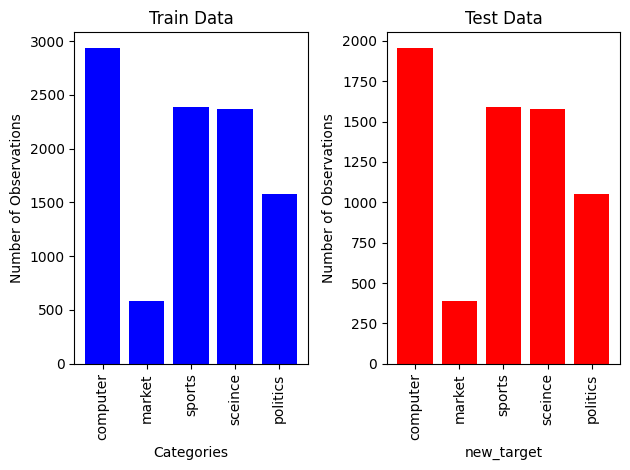

In [67]:

# Group and count the observations by 'new_target' for the train and test DataFrames
train_target_counts = train_df_3['new_target'].value_counts().sort_index()
test_target_counts = test_df_3['new_target'].value_counts().sort_index()

# Create subplots for train and test
fig, (ax1, ax2) = plt.subplots(1, 2)

category_labels = categories3

# Plot the bar chart for the train data
ax1.bar(category_labels, train_target_counts.values, color='blue')
ax1.set_title('Train Data')
ax1.set_xlabel('Categories')
ax1.set_ylabel('Number of Observations')
ax1.set_xticks(range(len(category_labels)))
ax1.set_xticklabels(category_labels, rotation=90)

# Plot the bar chart for the test data
ax2.bar(category_labels, test_target_counts.values, color='red')
ax2.set_title('Test Data')
ax2.set_xlabel('new_target')
ax2.set_ylabel('Number of Observations')
ax2.set_xticks(range(len(category_labels)))
ax2.set_xticklabels(category_labels, rotation=90)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [68]:
#Tokenization
train_df_3 ['data'] = train_df_3['data'] .apply(word_tokenize)
test_df_3['data']= test_df_3 ['data']. apply(word_tokenize)

In [69]:
preprocess_text(train_df_3, 'data')
preprocess_text(test_df_3,'data')

In [70]:
train_df_3.head()

data  target new_target
0  [wondering, anyone, could, enlighten, car, saw...       7          2
1  [fair, number, brave, soul, upgraded, si, cloc...       4          0
2  [well, folk, mac, plus, finally, gave, ghost, ...       4          0
3     [weitek, number, like, get, information, chip]       1          0
4  [article, tombaker, tom, baker, understanding,...      14          3

In [71]:
# Remove rows with empty or whitespace strings in the "data" column
train_df_3 = train_df_3[train_df_3['data'].apply(len) > 0]
test_df_3 = test_df_3[test_df_3['data'].apply(len) > 0]

In [72]:
train_df_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9575 entries, 0 to 11313
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   data        9575 non-null   object  
 1   target      9575 non-null   int64   
 2   new_target  9575 non-null   category
dtypes: category(1), int64(1), object(1)
memory usage: 234.0+ KB


In [73]:
test_df_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6358 entries, 0 to 7530
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   data        6358 non-null   object  
 1   target      6358 non-null   int64   
 2   new_target  6358 non-null   category
dtypes: category(1), int64(1), object(1)
memory usage: 155.4+ KB


In [74]:
word_count(train_df_3,'data')

word_count(test_df_1,'data')

Average Word Count :91.53953002610966
Maximum Word Count :6216
Minimum Word Count :1
Average Word Count :850.6542948038176
Maximum Word Count :32898
Minimum Word Count :3


<ipython-input-4-fbcef87b117d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['word_count'] = df [colomn_name].apply(len)


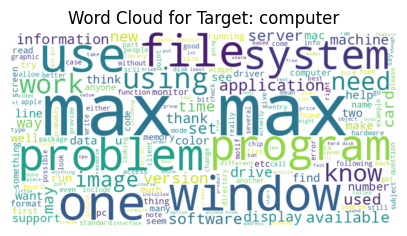

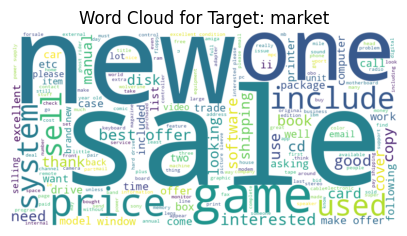

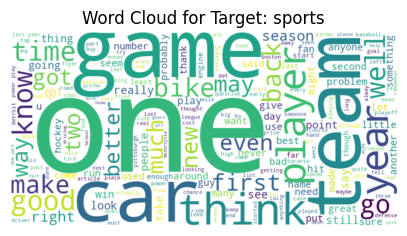

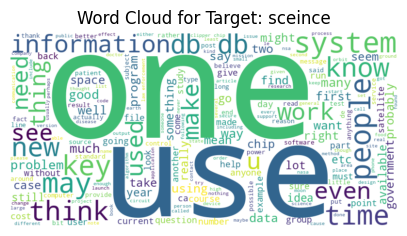

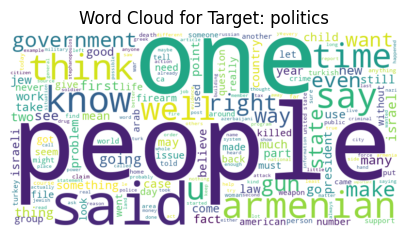

In [75]:

group_train_df_3 = train_df_3.groupby('new_target')

# Create a word cloud for each target
for target, group in group_train_df_3:
    # Combine the text data from the group into a single string
    combined_text = " ".join(group['data'].apply(lambda x: ' '.join(x)))

    # Generate a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

    target=categories3[target]

    # Display the word cloud with the target as the title
    plt.figure(figsize=(5, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for Target: {target}")
    plt.axis("off")
    plt.show()

In [76]:

# TF-IDF

train_df_3['data'] = train_df_3['data'].apply(lambda tokens: ' '.join(tokens))
test_df_3['data'] =test_df_3['data'].apply(lambda tokens:' '.join(tokens))

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X3_train = tfidf_vectorizer.fit_transform(train_df_3['data'])

X3_test = tfidf_vectorizer.transform(test_df_3['data'])

In [77]:

feature_names = tfidf_vectorizer.get_feature_names_out()
# Convert the TF-IDF matrix to a DataFrame
tfidf_df_3 = pd.DataFrame(X3_train.toarray(), columns=feature_names)

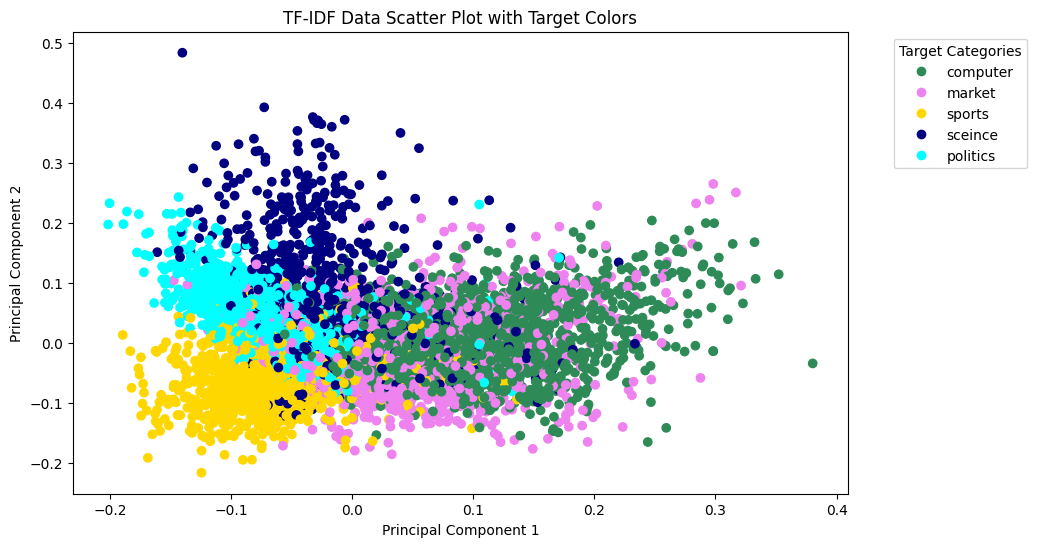

In [78]:
# Reduce the dimensionality of the TF-IDF data using PCA to make scatter plot.

pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
tfidf_df_reduced_3 = pca.fit_transform(tfidf_df_3)

# convert tfidf_df_reduced (array) to dataframe. There are 2 components (attribute) for this dataframe
tfidf_df_reduced_3 = pd.DataFrame(tfidf_df_reduced_3, columns=['PC1', 'PC2'])


# Add the 'target' column to tfidf_df_reduced for labeling purpose
tfidf_df_reduced_3['target'] = pd.Categorical(train_df_3['target'])

# Create a scatter plot with colors representing the target labels
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    tfidf_df_reduced_3['PC1'],
    tfidf_df_reduced_3['PC2'],
    c=tfidf_df_reduced_3['target'].cat.codes,  # Use categorical codes for color-coding
    cmap=custom_cmap
)

# Add legend with target category names and colors
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', label=category_name, markersize=8, markerfacecolor=color)
                 for category_name, color in zip(categories3, custom_colors)]

plt.legend(handles=legend_labels, title='Target Categories',bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('TF-IDF Data Scatter Plot with Target Colors')
plt.show()

In [79]:

#for Multinomial NaiveBayes method, use "MultinomialNB" function fromsklearn.naive_bayes
nb_classifier = MultinomialNB()
nb_classifier.fit(X3_train, train_df_3['new_target'])

MultinomialNB()

In [80]:
# use "accuracy_score" and "classification_report" function from sklearn.metrics

predictions = nb_classifier.predict(X3_test)
accuracy = accuracy_score(test_df_3['new_target'], predictions)

report = classification_report(test_df_3['new_target'], predictions, target_names=categories3)
print(f'Accuracy: {accuracy}')
print(report)

Accuracy: 0.8131487889273357
              precision    recall  f1-score   support

    computer       0.76      0.93      0.84      1909
      market       0.95      0.29      0.45       382
      sports       0.84      0.87      0.86      1524
     sceince       0.81      0.72      0.76      1519
    politics       0.88      0.83      0.85      1024

    accuracy                           0.81      6358
   macro avg       0.85      0.73      0.75      6358
weighted avg       0.82      0.81      0.80      6358



Multinomial Naive Bayes:
Cross-validation scores: [0.81932115 0.83133159 0.81618799 0.82767624 0.81671018]
Mean accuracy: 0.8222454308093994
Test accuracy: 0.8131487889273357

Logistic Regression:
Cross-validation scores: [0.84125326 0.83133159 0.82872063 0.84960836 0.84125326]
Mean accuracy: 0.8384334203655353
Test accuracy: 0.8210128971374646

Support Vector Machines:
Cross-validation scores: [0.84438642 0.83185379 0.82976501 0.85744125 0.84543081]
Mean accuracy: 0.8417754569190601
Test accuracy: 0.8203837684806543

Decision Trees:
Cross-validation scores: [0.63133159 0.64386423 0.6308094  0.62767624 0.64543081]
Mean accuracy: 0.635822454308094
Test accuracy: 0.6234664988990248

Random Forest:
Cross-validation scores: [0.76553525 0.77806789 0.76396867 0.78067885 0.77650131]
Mean accuracy: 0.7729503916449086
Test accuracy: 0.7474048442906575



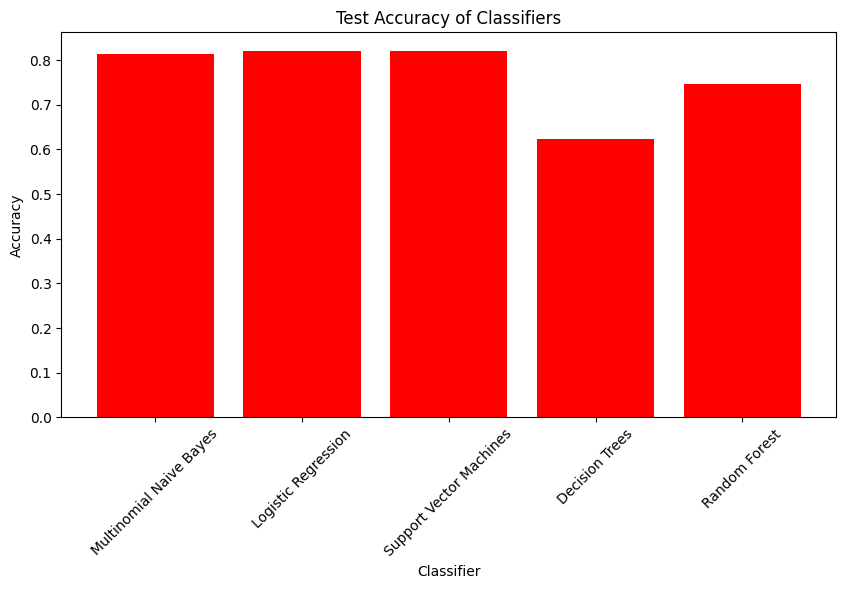

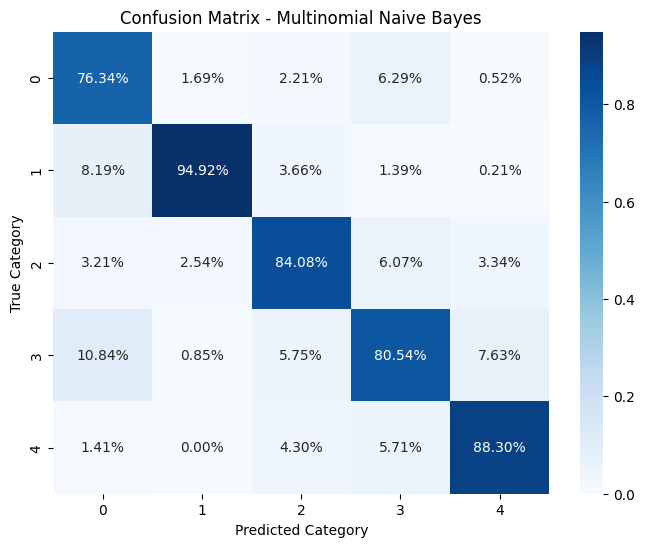

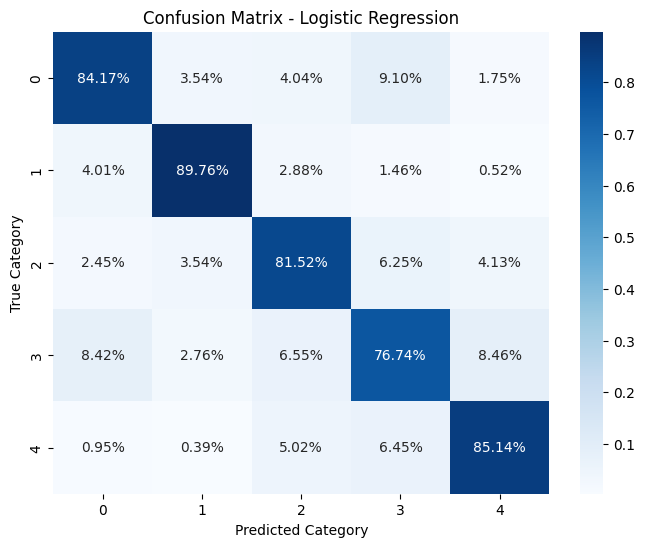

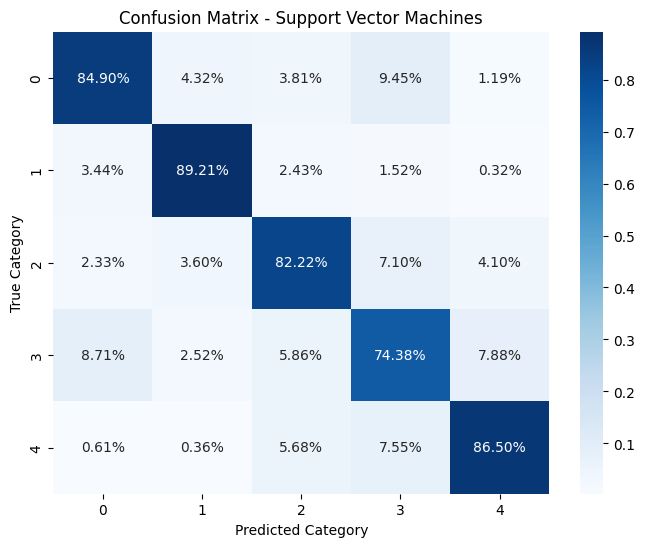

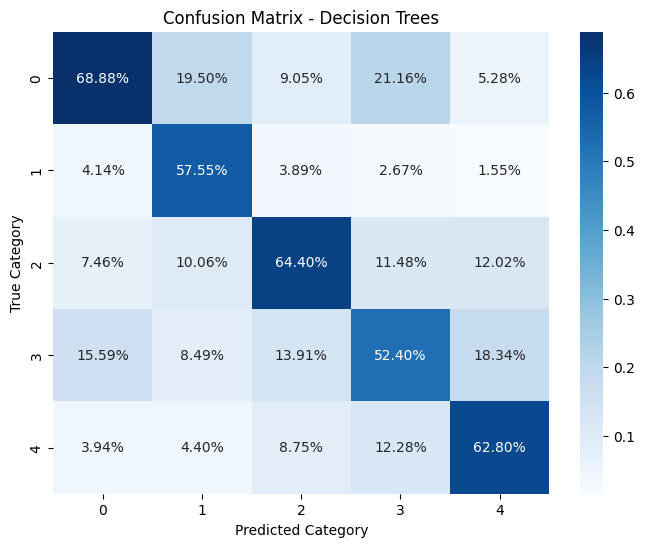

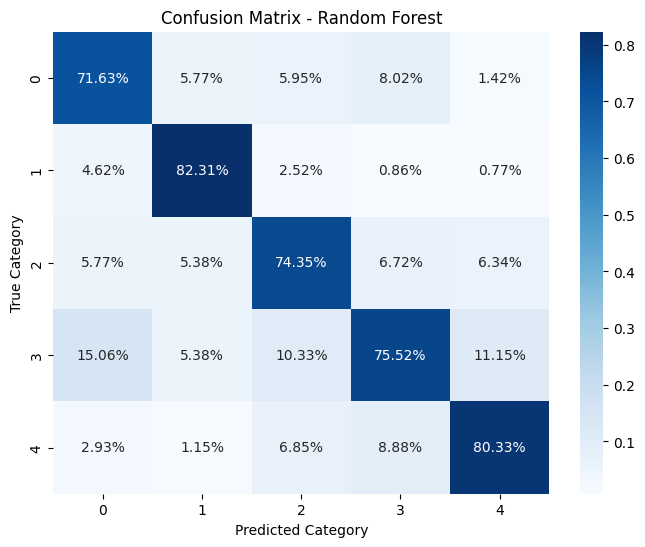

In [88]:
#support vector machine takes very long time (7min...)

# Lists to store results
classifier_names3 = []
cross_val_scores3 = []
test_accuracies3 = []
confusion_matrices3 = []

# Loop through each classifier and perform cross-validation
for name, classifier in classifiers.items():
    # Perform cross-validation on the classifier using X1_train and the target
    scores = cross_val_score(classifier, X3_train, train_df_3['new_target'], cv=5)  # cross_val_score(classification model, Training data, target attribute, K=5)  #5 fold cross validation

    # Train the classifier on X1_train and the target
    classifier.fit(X3_train, train_df_3['new_target'])

    # Use the trained classifier to make predictions on X1_test
    predictions = classifier.predict(X3_test)

    # Evaluate the accuracy on X1_test
    accuracy = accuracy_score(test_df_3['new_target'], predictions)

    # Generate the confusion matrix
    confusion = confusion_matrix(test_df_3['new_target'], predictions)

    # Store the results
    classifier_names3.append(name)
    cross_val_scores3.append(scores.mean())
    test_accuracies3.append(accuracy)
    confusion_matrices3.append(confusion)

    # Print the cross-validation results for the current classifier
    print(f'{name}:')
    print(f'Cross-validation scores: {scores}')
    print(f'Mean accuracy: {scores.mean()}')
    print(f'Test accuracy: {accuracy}\n')

# Create a bar plot for accuracy performance
plt.figure(figsize=(10, 5))
plt.bar(classifier_names3, test_accuracies3, color='red')
plt.title('Test Accuracy of Classifiers')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

# Show the bar plot
plt.show()

# Create heat maps of confusion matrices with classifier names as titles
for i, name in enumerate(classifier_names3):
    plt.figure(figsize=(8, 6))

    # Normalize the confusion matrix to percentages per column (predicted values)
    normalized_confusion_matrix = confusion_matrices3[i] / confusion_matrices3[i].sum(axis=0)

    sns.heatmap(normalized_confusion_matrix, annot=True, fmt='.2%', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted Category')
    plt.ylabel('True Category')

    # Show the heat map
    plt.show()